## Assignment 3: Task 2 - Radial Distribution Function (RDF) determination
### Goal: compute the $1^{st}$ solvation shell of $Na^+$ in water.

### Note for myself (not directly related to this Task in specific):
If the Na $^{+}$ ion is placed too close to another atom, then we will have an extraordinarily strong force that will kick the interacting atoms away. This might results in the kind of oscillatory motion that we saw before in Snapshot_3. The excess kinetic energy is taken out of the system by the thermostat that's in place!

In [49]:
from ase.io import read

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, interp1d
from scipy.integrate import simpson, quad, romberg
from scipy.optimize import fmin

In [50]:
# Reading all snapshots (trajectory).
# trajs = read(f'Snapshot_12000/Task1_Dynamics.traj', index='1000:')                                            # Our AIMD simulation.
trajs = read(f'./tif320-computational-materials-and-molecular-physics/Na-aimd/NaCluster24.traj', index='1000:') # Reference.

# Getting volume from the first snapshot.
Vol = trajs[0].get_volume()          
Cell = trajs[0].get_cell()                               
print(f'Unit cell volume = {Vol} [A^3].')
print(f'Cell dimensions = {Cell} [A].')

# Total number of snapshots read.
snap_n = len(trajs); print(f'Number of snaphots = {snap_n}.')

Unit cell volume = 718.449183 [A^3].
Cell dimensions = Cell([8.956369831609006, 8.956369831609006, 8.956369831609006]) [A].
Number of snaphots = 13000.


In [51]:
# Definitions:
n_bins = 100
r_max  = Cell[0, 0]/2      # Periodic boundary conditions means we can re-center ('the cell') around each individual atom. So, r_max = Cell_x/2.
print(f'r_max = {r_max}.') 
                           # r_max = 4 should work with no problems.
max_d = []                 # Checking what is the biggest distance that is verified.
global_count = np.zeros(n_bins)

for snapshot in trajs:
    atoms = snapshot[:24]      # Selecting the 24 'O' atoms.
    atoms.append(snapshot[-1]) # Adding the 'Na' atom.

    dist = atoms.get_all_distances(mic = True)[-1][:-1] # [:-1] to get rid off the Na distance (0).
    max_d.append(sorted(dist)[-1])                      # Checking what is the biggest distance that is verified.

    counts, bins  = np.histogram(dist, bins = np.linspace(0, r_max, n_bins + 1, endpoint = True))

    global_count += counts

# Averaging over all the snapshots:
global_count /= snap_n
print(f'Maximum verified distance = {sorted(max_d)[-1]}.')

r_max = 4.478184915804503.
Maximum verified distance = 6.966056577890978.


In [52]:
# Definitions:
final_count = np.zeros(n_bins)
dr          = bins[1] - bins[0]
ind         = list(range(n_bins))

# Number density? We're not really sure how this is defined. Will need to check...
Vol_Max = (4/3)*np.pi*(r_max**3)
rho = sum(global_count)/Vol_Max

print(f'sum(global_count) = {sum(global_count)}.')
print(f'Value of \\rho = {rho}.')               # These two are reasonably close... So, that's probably not the problem.
print(f'Value of \\rho (Unit cell)= {24/Vol}.') # These two are reasonably close... So, that's probably not the problem.

for bin_count, r, i in zip(global_count, bins, ind): # This doesn't seem to work very well. I guess that's not the definition.
    if (bin_count > 0):
        Volume = 4*np.pi*(r**2)*dr
        final_count[i] = bin_count/(Volume*rho)

sum(global_count) = 12.866846153846156.
Value of \rho = 0.034204041970009015.
Value of \rho (Unit cell)= 0.033405285395111936.


### Another note:
So, I believe the problem is that, if we consider $r_{max}$ to be 'too' big, then our $\textbf{Sphere}$ will get out of the 'Unit Cell'. We should consider $\textbf{Spherical Caps}$, instead! I keep $r_{max}$ = 4 (Relatively low! Note how $\verb|sum(global_count)|$ $\approx 8$, instead of the maximum 24). I guess we can ask about this on Thursday. Whether or not we should implement it, that is.

### One more note:
The function to integrate is $\rho \cdot g_{\alpha \beta} (r)$! $g_{\alpha \beta} (r)$ describes the $\textbf{relative density of atoms}$ (Oxygen in this case) as a function of the radius (Distance from the 'central' Na atom). The transformation to spherical coordinates introduces the $4 \pi r^2$ factor (in the integrand).

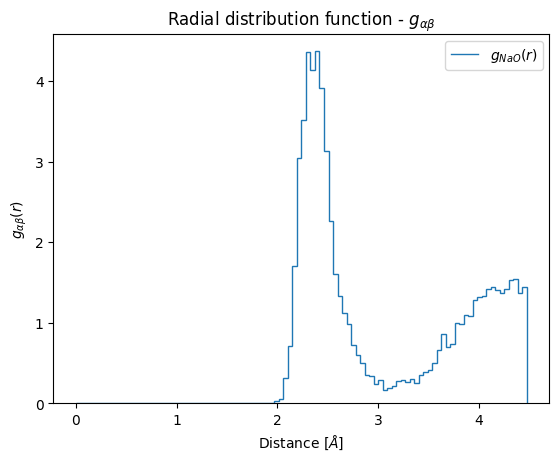

Total integral = 12.593346153846156.


In [53]:
# Plotting resulting histogram:
plt.stairs(final_count, bins, fill = False, label = r'$g_{Na O} (r)$')
# plt.grid(True)
plt.xlabel(r'Distance [$\AA$]')
plt.ylabel(r'$g_{\alpha \beta} (r)$')
plt.title(r'Radial distribution function - $g_{\alpha \beta}$')
plt.legend()
plt.show()

Integrand = np.zeros(len(bins[:-1]))
for i, r_i in enumerate(bins[:-1]):
    Integrand[i] = 4*np.pi*r_i**2 * rho * final_count[i] # Integrand = 4*pi*r^2 * \rho * g

# Trapezoidal rule.
print(f'Total integral = {np.trapz(Integrand, dx = dr)}.') # This is integrating everything! Not just until the first minimum, or whatever it was.

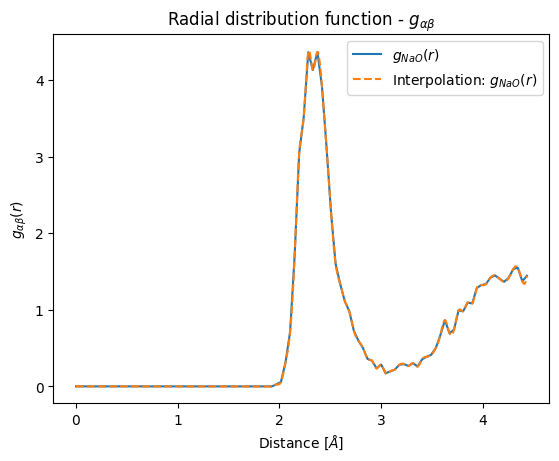

Total integral (Interpolator)= (12.580096477235841, 1.7729823639727887e-07).
Total integral (Discrete bins)= 12.590179487179485.


In [54]:
# CubicSpline/interp1d:
Interpolator = interp1d(bins[:-1], final_count, kind = 'cubic')
xnew = np.linspace(0, bins[-2], 50000, endpoint = True) # Here we have '-2', because we left out the last value of r, above.
ynew = Interpolator(xnew)

# Plotting results as graph:
plt.plot(bins[:-1], final_count, label = r'$g_{Na O} (r)$')
plt.plot(xnew, ynew, linestyle = 'dashed', label = r'Interpolation: $g_{Na O} (r)$')

# plt.grid(True)
plt.xlabel(r'Distance [$\AA$]')
plt.ylabel(r'$g_{\alpha \beta} (r)$')
plt.title(r'Radial distribution function - $g_{\alpha \beta}$')
plt.legend()
plt.show()

# For integration, using quad (Interpolator).
func = lambda r: 4*np.pi*r**2 * rho * Interpolator(r)
print(f'Total integral (Interpolator)= {quad(func, bins[0], bins[-2], limit = 150)}.') # This is integrating everything!
                                                                                       # Not just until the first minimum, or whatever it was.

# Simpson method, for comparison with the trapezoidal rule used before.
print(f'Total integral (Discrete bins)= {simpson(Integrand, x = bins[:-1])}.') # This is integrating everything!

In [55]:
a = 0; b = fmin(Interpolator, 2.5)[0]                            # b - Minimum value (r).
print(f'Found minimum: r = {b}.')
print(f'1st solvation shell = {quad(func, a, b, limit = 150)}.') # Integrating until the obtained r value.

Optimization terminated successfully.
         Current function value: 0.163091
         Iterations: 16
         Function evaluations: 33
Found minimum: r = 3.0560302734375.
1st solvation shell = (4.4449168979099145, 6.552811947414167e-08).


The obtained value for the $1^{st}$ solvation shell was 3.463, which is reasonably far away from the experimental value of 5.
I also performed the same computations with the provided (in the $\verb|git|$ repository) $\verb|.traj|$ file, and a value of 4.445 was found for the $1^{st}$ solvation shell, which is definitely closer to the expected result.

## Extra: checking thermal equilibrium with the $\verb|.log|$ file.
### Note: will use $\verb|pandas|$ for reading the $\verb|.log|$ file.

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

In [57]:
# Reading all snapshots (trajectory).
# log_df = pd.read_csv(f'./tif320-computational-materials-and-molecular-physics/Na-aimd/NaCluster24.log', sep = '\s+', skiprows = 1, \
#          names = ['t', 'E_tot', 'E_pot', 'E_kin', 'T']) # Reference.
log_df = pd.read_csv(f'./Snapshot_12000/Task1_MD_Output.log', sep = '\s+', skiprows = 1, \
         names = ['t', 'E_tot', 'E_pot', 'E_kin', 'T']) # Our AIMD Simulation.
time = log_df['t']; T = log_df['T']; E = log_df['E_tot']

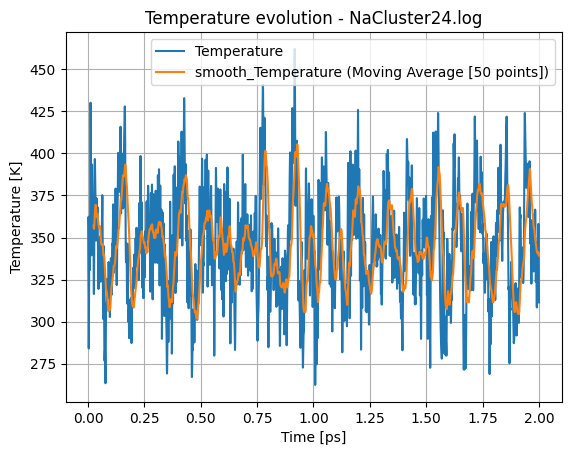

In [58]:
# Smoothing - through 'Moving Average'. (Sort of a low-pass filter)
smooth_T = pd.Series(T).rolling(window = 50).mean()

# Plotting results as graph:
plt.plot(time, T, label = r'Temperature')
plt.plot(time, smooth_T, label = r'smooth_Temperature (Moving Average [50 points])')

# plt.grid(True)
plt.xlabel(r'Time [ps]')
plt.ylabel(r'Temperature [K]')
plt.title(r'Temperature evolution - NaCluster24.log')
plt.grid(True)
plt.legend()
# plt.savefig('Task2_Temperature_Graph_Ref.png', dpi = 500)
plt.show()

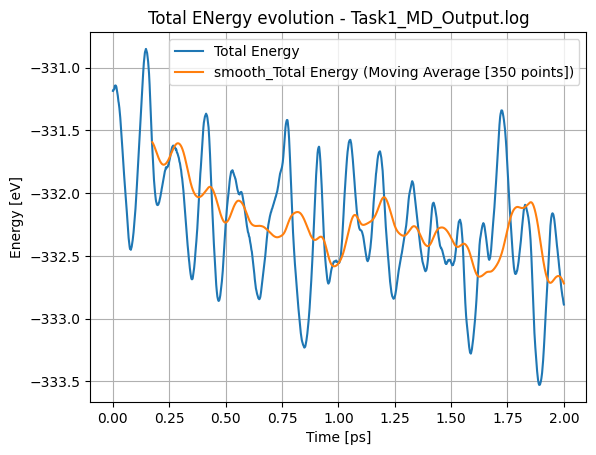

In [59]:
# Smoothing - through 'Moving Average'. (Sort of a low-pass filter)
smooth_E = pd.Series(E).rolling(window = 350).mean()

# Plotting results as graph:
plt.plot(time, E, label = r'Total Energy')
plt.plot(time, smooth_E, label = r'smooth_Total Energy (Moving Average [350 points])')

# plt.grid(True)
plt.xlabel(r'Time [ps]')
plt.ylabel(r'Energy [eV]')
plt.title(r'Total ENergy evolution - Task1_MD_Output.log')
plt.grid(True)
plt.legend()
plt.savefig('Task2_Energy_Graph.png', dpi = 500)
plt.show()

I wanted to ask if the initial AIMD simulation already considers periodic boundary conditions. It seems weird that they show a cube in $\verb|ase gui|$, with molecules outside of it! Shouldn't they all be inside? Yes, but in the $\verb|.traj|$ file, they don't bother wrapping them around. Internally, they store it as some value $mod$ unit cell's length.

## Remember!
- Plot the total energy, instead of T, to averiguate equilibrium; Done!$\\$
- Periodic boundary conditions means we can re-center ('the cell') around each individual atom. So, $\verb|r_max = Cell_x/2|$; Done!
- Add that our result in Task 3 agrees the most with the modified version of PBE (the one that includes Van der Waals, I think), which makes perfect sense; Done!
- Remove the first few Snapshots (1000 or so) to guarantee that (some) equilibrium is reached. Neglects possible transients at the start. DOne!

## Change T_Graphs' descriptions.